# Simple Spam Classifier

To train the basics of Natural Language Processing (NLP), here is a little project about the spam/ham classification. 

As I'm closely following the *great* book _Python Machine Learning_ by Sebastian Raschka, the code is largely similar to its Chapter 8 _Applying Machine Learning to Sentiment Analysis_, where a movie review classifier is implemented. The **original aspect** is applying the method to another problem and dataset: spam detection from the Apache spam and ham e-mail corpus.

Dataset Source: https://spamassassin.apache.org/old/publiccorpus/

## Learning goals:
- Form a dataset from thousands of text files
- Inspect its structure
- Preprocess and clean it
- Implement a __Bag of Words Model__ using the __Count Vectorizer__
- Correct for word relevancy with the __Term-Frequency-Inverse-Document-Frequency__ (tf-idf) technique
- Train and optimise the **Logistic Regression** model
- Evaluate performance on a test set
- Compare with *out-of-core* learning
- Try to deploy the model on a web server
- Try and find clusters of topics within the spam e-mails

## "Business" goal:
- Distinguish spam from ham with possibly high _recall_ (i.e. maximising the chance of detecting spam) and _precision_ (i.e. minimising _false positive_ rate of non-spam misclassified as spam)

## Load the data

In [61]:
HAM_FOLDER = "spamassassin.apache.org/old/publiccorpus/easy_ham/"
SPAM_FOLDER = "spamassassin.apache.org/old/publiccorpus/spam/"

import glob
import numpy as np

HAM_FILES = glob.glob(HAM_FOLDER+'*')
SPAM_FILES = glob.glob(SPAM_FOLDER+'*')

print("Number of *ham* files: %d" % len(HAM_FILES))
print("Number of *spam* files: %d" % len(SPAM_FILES))

Number of *ham* files: 5052
Number of *spam* files: 1002


Let's have a look at some examples of spam and ham with a help of the function below.

In [62]:
def peek(file_list, index, keywords=[], show_only_keywords=False):
    """Display content of the file `file_list[index]`.
    Find keywords and display their location after the file content."""
    with open(file_list[index], 'r') as f:
        # Remove end-of-line
        lines = [line.strip() for line in f.readlines()]
    res = []
    for i, line in enumerate(lines):
        if not show_only_keywords:
            print(line)
        for keyword in keywords:
            if keyword in line:
                res.append(f"Line {i} has the keyword `{keyword}`: {line}")
    if len(res) > 0:
        print("KEYWORD SEARCH RESULTS:")
        print(res)

In [63]:
peek(SPAM_FILES, 0)

From WebBuilders@YourService.com  Thu Sep 26 11:11:58 2002
Return-Path: <WebBuilders@YourService.com>
Delivered-To: zzzz@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
by zzzzason.org (Postfix) with ESMTP id D4FFF16F03
for <zzzz@localhost>; Thu, 26 Sep 2002 11:11:55 +0100 (IST)
Received: from jalapeno [127.0.0.1]
by localhost with IMAP (fetchmail-5.9.0)
for zzzz@localhost (single-drop); Thu, 26 Sep 2002 11:11:55 +0100 (IST)
Received: from webnote.net (mail.webnote.net [193.120.211.219]) by
dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8PISRC08752 for
<zzzz@jmason.org>; Wed, 25 Sep 2002 19:28:27 +0100
Received: from rack3.easydns.com (rack3.easydns.com [205.210.42.50]) by
webnote.net (8.9.3/8.9.3) with ESMTP id TAA27238 for <zzzz@spamassassin.taint.org>;
Wed, 25 Sep 2002 19:29:02 +0100
Received: from 52.25.36.25 (216-91-88-22.biltmorecomm.com [216.91.88.22])
by rack3.easydns.com (Postfix) with SMTP id 9821F4BE98 for
<zzzz@spamassassin.taint.org>; W

In [64]:
peek(HAM_FILES, 0)

From rssfeeds@jmason.org  Tue Oct  1 10:36:33 2002
Return-Path: <rssfeeds@example.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
by jmason.org (Postfix) with ESMTP id 11E6316F56
for <jm@localhost>; Tue,  1 Oct 2002 10:36:05 +0100 (IST)
Received: from jalapeno [127.0.0.1]
by localhost with IMAP (fetchmail-5.9.0)
for jm@localhost (single-drop); Tue, 01 Oct 2002 10:36:05 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g9181CK15579 for
<jm@jmason.org>; Tue, 1 Oct 2002 09:01:12 +0100
Message-Id: <200210010801.g9181CK15579@dogma.slashnull.org>
To: yyyy@example.com
From: fark <rssfeeds@example.com>
Subject: Motel holds mans wheelchair ransom.
Date: Tue, 01 Oct 2002 08:01:12 -0000
Content-Type: text/plain; encoding=utf-8
X-Spam-Status: No, hits=-572.3 required=5.0
tests=AWL
version=2.50-cvs
X-Spam-Level:

URL: http://www.newsisfree.com/click/-1,8410271,1717/
Date: 2002-09-

We notice there might be a lot of html code in the e-mails.
Perhaps spam has more html code to attract attention with colours and widgets.
It seems the degree of html usage might help in classification.



In [65]:
for category in ("ham", "spam"):
    print(category)
    print(50*'=')
    files = HAM_FILES if category=='ham' else SPAM_FILES
    for i in range(10):
        peek(files, i, ["Subject:"], show_only_keywords=True)

ham
KEYWORD SEARCH RESULTS:
['Line 15 has the keyword `Subject:`: Subject: Motel holds mans wheelchair ransom.']
KEYWORD SEARCH RESULTS:
['Line 20 has the keyword `Subject:`: Subject: Re: [SAtalk] dependencies / pre-requisites for installation in']
KEYWORD SEARCH RESULTS:
['Line 32 has the keyword `Subject:`: Subject: Re: [SAtalk] getting single-user spam assassin to work in FreeBSD']
KEYWORD SEARCH RESULTS:
['Line 15 has the keyword `Subject:`: Subject: Scoble: "I\'m just not that excited by much that Microsoft is doing."']
KEYWORD SEARCH RESULTS:
['Line 27 has the keyword `Subject:`: Subject: Re: [SAtalk] Re: SA In The News']
KEYWORD SEARCH RESULTS:
['Line 15 has the keyword `Subject:`: Subject: Is rap music art? Rap song about farting answers that question']
KEYWORD SEARCH RESULTS:
['Line 28 has the keyword `Subject:`: Subject: Re: A moment of silence for the First Amendment (fwd)']
KEYWORD SEARCH RESULTS:
["Line 15 has the keyword `Subject:`: Subject: 'Nasty party' warning to Torie

Many e-mails are an obvious spam or ham:
- *spam*: the ones promising miracles or discussing "measurements" ;-)
- *ham*: the opposite: no miracles but opinions or facts (the news); replies to questions

Nonetheless, some message subjects are less obvious and even ham-sounding ones may have spam in the main body.
Therefore, full message should be analysed.
What is more, the e-mail headers with addresses might be of use too: the domain name or the user before '@' can be indicative of spam (e.g. if it is a random bundle of characters). So, we'll keep these too.

## Data preprocessing

Now we will form a pandas dataset from all the selected documents.

In [66]:
import pyprind # nice progress bar
import pandas as pd
import os

try:
    import magic # deduce file encoding
except:
    %pip install python-magic
    import magic

def deduce_encoding(file_name):
    blob = open(file_name, 'rb').read()
    m = magic.Magic(mime_encoding=True)
    return m.from_buffer(blob)

labels = {'spam': 1, 'ham': 0}
def merge_data():
    pbar = pyprind.ProgBar(len(SPAM_FILES)+len(HAM_FILES))
    df = pd.DataFrame()
    for l in ('spam', 'ham'):
        files = SPAM_FILES if l=='spam' else HAM_FILES
        for file in files:
            try:
                encoding = 'utf-8' # (For now use utf-8 only) alternatively: deduce_encoding(file)
                #print("Encoding:", encoding)
                with open(file, 'r', encoding=encoding) as infile:
                    txt = infile.read().replace('\n', ' ')
                df = df.append([[txt, labels[l]]],
                                 ignore_index=True)
                pbar.update()
            except:
                print("Problem with file", file)
                print("Skipping it")
                continue
    df.columns = ['message', 'type']
    print(df.head())
    # Let's shuffle the dataset
    np.random.seed(42)
    df = df.reindex(np.random.permutation(df.index))

    # Save the dataset into a csv file
    # Same encoding for all the messages may render some characters illegible
    df.to_csv("spam_data.csv", index=False, encoding='utf-8')

if not os.path.exists("spam_data.csv"):
    merge_data()

Above we accepted only the documents encoded using the utf-8 standard.
Using the alternative, commented out, approach (`deduce_encoding(file)`) enables to extend a little the dataset, dropping only the files even the `magic` library has no spell for (e.g. binary or 8-bit files).
However the latter option causes trouble in the topic modelling at the end of this notebook. Therefore the former way is used.

In [67]:
# Read the csv
df = pd.read_csv("spam_data.csv", encoding='utf-8')

df.head(15)

,message,type
0,From fork-admin@xent.com Sun Sep 22 23:59:01 ...,0
1,From fork-admin@xent.com Wed Oct 2 16:02:24 ...,0
2,From pudge@perl.org Thu Sep 26 11:02:41 2002 ...,0
3,From rssfeeds@jmason.org Thu Oct 3 12:25:14 ...,0
4,From rpm-list-admin@freshrpms.net Tue Oct 8 ...,0
5,From rssfeeds@jmason.org Mon Sep 30 13:44:06 ...,0
6,From ilug-admin@linux.ie Tue Oct 8 11:13:35 ...,0
7,From fork-admin@xent.com Sun Oct 6 22:57:39 ...,0
8,From rpm-list-admin@freshrpms.net Fri Sep 6 ...,0
9,From rssfeeds@jmason.org Mon Sep 30 13:43:38 ...,0


In [68]:
df.shape

(5604, 2)

In [69]:
df['type'].value_counts()

0    4769
1     835
Name: type, dtype: int64

In [70]:
df['type'].sum() / df.shape[0]

0.14900071377587437

In [71]:
df["type"].value_counts()

0    4769
1     835
Name: type, dtype: int64

In [72]:
df.shape

(5604, 2)

Above we saw that only 15% of data corresponds to spam.
We should not be worried by that as long as the resulting classifier has decent both, precision and recall (sensitivity) (accuracy score is less interesting, since it is biased by the majority, non-spam, messages).

## Bag Of Words Model
To distinguish spam from ham we are going to use Logistic Regression.
However we cannot feed simply the e-mails into that algorithm.
We will clean it and preprocess forming vectors of frequencies of _n-grams_ ($n$-length sequences of subsequent words in the document) with the Bag of Words Model.

Now is time to clean the data. To this end we will be using regular expressions (module `re`) and the Natural Language Toolkit (`nltk`). The latter one, in particular, contains a list of 'stop-words', i.e. not-so-meaningful words that should not be of much help to our classifier.

Also, it seems pertinant to know how often the e-mails contain incorrect English.
Perhaps spam has more spelling mistakes (or non-existing words).
We will use the `enchant` module for the task.

In [73]:
try:
    import enchant
except:
    %pip install pyenchant

d = enchant.Dict("en_US")
def correct_english(word):
    return d.check(word)
for word in ("I'm", "Hello!", "50", "$50", "ttypo", "hi@there", "html", "Thu", "Sep"):
    print("Is word *%s* correct English? %s" %(word,correct_english(word)))
d.add("html")
print("Is html correct now?", correct_english("html"))
months = "Jan Feb Mar Apr Mai Jun Jul Aug Sep Oct Nov Dec".split()
for m in months:
    print("Is %s correct English? %s" % (m, correct_english(m)))
d.add("Sep") # Oops. Just informed pyenchant developers about this bug :-)


Is word *I'm* correct English? True
Is word *Hello!* correct English? False
Is word *50* correct English? True
Is word *$50* correct English? False
Is word *ttypo* correct English? False
Is word *hi@there* correct English? False
Is word *html* correct English? True
Is word *Thu* correct English? True
Is word *Sep* correct English? True
Is html correct now? True
Is Jan correct English? True
Is Feb correct English? True
Is Mar correct English? True
Is Apr correct English? True
Is Mai correct English? True
Is Jun correct English? True
Is Jul correct English? True
Is Aug correct English? True
Is Sep correct English? True
Is Oct correct English? True
Is Nov correct English? True
Is Dec correct English? True


In [74]:
help(enchant)

Help on package enchant:

NAME
    enchant

DESCRIPTION
    enchant:  Access to the enchant spellchecking library
    
    This module provides several classes for performing spell checking
    via the Enchant spellchecking library.  For more details on Enchant,
    visit the project website:
    
        https://abiword.github.io/enchant/
    
    Spellchecking is performed using 'Dict' objects, which represent
    a language dictionary.  Their use is best demonstrated by a quick
    example::
    
        >>> import enchant
        >>> d = enchant.Dict("en_US")   # create dictionary for US English
        >>> d.check("enchant")
        True
        >>> d.check("enchnt")
        False
        >>> d.suggest("enchnt")
        ['enchant', 'enchants', 'enchanter', 'penchant', 'incant', 'enchain', 'enchanted']
    
    Languages are identified by standard string tags such as "en" (English)
    and "fr" (French).  Specific language dialects can be specified by
    including an additional co

We just saw only raw words and numbers, with no punctuation nor "$" sign are considered _correct_.
We spotted that the dictionary does not recognise 'html', so we have added that word.

In [75]:
try:
    from profanity_filter import ProfanityFilter
except:
    %pip install profanity-filter
# Also need: python spacy download en

In [76]:
pf = ProfanityFilter()

In [77]:
for w in ("Oh shit!", "I love you!", "Dick is a short for Richard", "Little cat is a pussy cat"):
    print("**%s** should be censored? %s" %(w, pf.is_profane(w)))

**Oh shit!** should be censored? True
**I love you!** should be censored? False
**Dick is a short for Richard** should be censored? True
**Little cat is a pussy cat** should be censored? True


In [168]:
ind="blababall Subject: fekfwjlkej faeklj".find("Subject:")
"blababall Subject: fekfwjlkej faeklj"[ind:]

'Subject: fekfwjlkej faeklj'

In [169]:
import re
try:
    import nltk
except:
    %pip install nltk
try:
    from nltk.corpus import stopwords
except:
    nltk.download('stopwords')
stop = stopwords.words('english')
def preprocessor(text, lowercase=True, check_lang=True,
                 skip_header=False):
    """Let's clean the message, tokenize the result and remove stop words
    
    Cleaning does the following:
    - removing end-of-line characters and other non-word characters
    - replace $ by `_dollar_`
    - replacing HTML with `_HTML_` (spam has more HTML probably)
    - replacing numbers with `_number_`
    - replacing incorrect English with `_INCORRECT_ENG_`
    """
    if skip_header:
        ind = text.find("Subject:")
        if ind == -1:
            return "EMPTY"
        text = text[ind:]
    text = re.sub(r'<[^>]*>', ' HTML ', text)
    text = re.sub(r'\$', ' DOLLAR ', text)
    #text = ' '.join([w if pf.is_clean(w) else " CENSURED " for w in text.split()]) # takes long time
    if check_lang:
        text = ' '.join([w if correct_english(w) else " INCORRECT_ENG " for w in text.split()])
    text = re.sub(r'[0-9]+\.?[0-9]*', ' NUMBER ', text)
    # remove non-words (NB. does not remove incorrect 'words')
    text = re.sub(r'[\W]+', ' ', text) 
    text = ' '.join([w for w in text.split() if w.lower() not in stop])
    if lowercase:
        return text.lower()
    return text
    #TODO: add params and use them in grid search(?)

# Let's save altenative preprocessors as separate functions    
from functools import partial
preprocessor_keep_uppercase = partial(preprocessor, lowercase=False)
preprocessor_no_lang_check = partial(preprocessor, check_lang=False)
preprocessor_no_header_no_lang = partial(preprocessor, skip_header=True, check_lang=False)
# import re
# def preprocessor(text):
#     """Let's clean the message by:
#     - removing end-of-line characters
#     - replace $ by `dollar`
#     - replacing HTML with `HTML` (spam has more HTML probably)
#     """
#     text = re.sub('<[^>]*>', ' HTML ', text)
#     text = re.sub('\$', ' dollar ', text)
#     #emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
#     # remove non-words and make the text lowercase (simplification)
#     text = re.sub('[\W]+', ' ', text.lower()) 
#     return text


In [188]:
print(preprocessor("Oh, shit, I don't have ttypo $50")) # "I" is a stop word
print(preprocessor("I give you ttypo and $50")) # 'you' and 'and' are stop words -> removed
print(preprocessor_no_lang_check("I give you ttypo and $50"))
print(preprocessor_no_header_no_lang("I give you ttypo and $50"))

incorrect_eng incorrect_eng incorrect_eng dollar number
give incorrect_eng dollar number
give ttypo dollar number
EMPTY


In [189]:
preprocessor_keep_uppercase("I WANT TO DO IT")

'WANT'

In [190]:
preprocessor("<email:bla@bla.com>")

'html'

In [173]:
preprocessor("<something\>")

'html'

In [174]:
preprocessor("Thu 25 Sep")

'thu number sep'

In [175]:
df.loc[0, "message"].split('\n')

['From fork-admin@xent.com  Sun Sep 22 23:59:01 2002 Return-Path: <fork-admin@xent.com> Delivered-To: yyyy@localhost.spamassassin.taint.org Received: from localhost (jalapeno [127.0.0.1]) \tby jmason.org (Postfix) with ESMTP id 3494216F03 \tfor <jm@localhost>; Sun, 22 Sep 2002 23:59:01 +0100 (IST) Received: from jalapeno [127.0.0.1] \tby localhost with IMAP (fetchmail-5.9.0) \tfor jm@localhost (single-drop); Sun, 22 Sep 2002 23:59:01 +0100 (IST) Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org     (8.11.6/8.11.6) with ESMTP id g8MMssC18527 for <jm@jmason.org>;     Sun, 22 Sep 2002 23:54:54 +0100 Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)     with ESMTP id BB1302940A8; Sun, 22 Sep 2002 15:51:07 -0700 (PDT) Delivered-To: fork@spamassassin.taint.org Received: from mail.evergo.net (unknown [206.191.151.2]) by xent.com     (Postfix) with SMTP id B3EF729409A for <fork@xent.com>; Sun,     22 Sep 2002 15:50:06 -0700 (PDT) Received: (qmail 32383 i

In [176]:
preprocessor(df.loc[1, "message"]).split('\n')

['incorrect_eng wed oct number incorrect_eng number incorrect_eng html incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng id incorrect_eng html incorrect_eng incorrect_eng number oct number incorrect_eng incorrect_eng incorrect_eng incorrect_eng jalapeno incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng number oct number incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng id incorrect_eng html incorrect_eng incorrect_eng number oct number incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng id incorrect_eng incorrect_eng number oct number incorrect_eng number incorrect_eng incorrect_eng incorrect_eng incorrect_eng number number incorrect_eng incorrect_eng incorrect_eng incorrect_eng incorrect_eng id incorrect_eng html in

In [177]:
from sklearn.base import BaseEstimator, TransformerMixin

class Cleaner(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        cleaner_vec = np.vectorize(self.preprocessor)
        return cleaner_vec(X)


Next, for the Bag Of Words model, we need to get the _words_.
The simplest way is to split the text by the usual word-delimiting characters, i.e. spaces, tabs, new-line characters, etc. An alternative is to use a 'stemmer' to ignore the word suffixes and, for example, treat _work_, _working_ and _worked_ as the same word. To this end we will be using the Porter Stemmer.

In [178]:
    
def tokenizer(text):
    "Simple tokenizer"
    return text.split()

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    "Porter Tokenizer: use only stems of words"
    return [porter.stem(word) for word in text.split()]
tokenizer_porter("Run Forest Run!!! Running is boring and causes boredom.")

['run', 'forest', 'run!!!', 'run', 'is', 'bore', 'and', 'caus', 'boredom.']

As we can see above, the Porter Stemmer is not an ideal approach: 'caus' should have been 'cause'.
Nevertheless, it does reduce dimensionality of the problem.
Regarding the punctuation marks, they are taken care of by the preprocessor already and will not be seen by the tokenizer.

In [179]:
#df['message'] = df['message'].apply(preprocessor)

Let us take 80% of the dataset for a train test and 20% for a test set.

In [180]:
train_size = int(0.8*df.shape[0])

In [181]:
train_size

4483

In [182]:
X_train = df.loc[:train_size, 'message'].values
y_train = df.loc[:train_size, 'type'].values
X_test = df.loc[train_size:, 'message'].values
y_test = df.loc[train_size:, 'type'].values

Term frequency is how often a given term appears in a document (normalised to unity).
It is a useful property, but an even better one is the _term frequency-inverse document frequency (tf-idf)_, which attributes a smaller importance to the words occurring across all the documents, focusing on the discriminating ones between the document classes.
Below we will be using the tf-idf transformer `TfidfVectorizer` to create the Bag of Words model with the tf-idf technique.

In [183]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False, # don't convert to lowercase
                        preprocessor=None)
param_grid = [
              {'vect__ngram_range': [(3,3)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer,
                                   tokenizer_porter],
               'clf__penalty': ['l1'],
               'clf__C': [100.0]},
#               {'vect__ngram_range': [(1,1), (2,2), (3,3)],
#                'vect__stop_words': [stop, None],
#                'vect__tokenizer': [tokenizer,
#                                    tokenizer_porter],
#                'vect__use_idf': [False],
#                'vect__norm': [None],
#                'clf__penalty': ['l1', 'l2'],
#                'clf__C': [100.0, 1000.0, 10000]},
             ]
prepare_and_model_pipeline = Pipeline([
                     ('preprocessor', 
                          Cleaner(preprocessor_no_header_no_lang)),
                     ('vect', tfidf),
                     ('clf',
                      LogisticRegression(random_state=42,
                                         solver='liblinear'))])
gs_lr_tfidf = GridSearchCV(prepare_and_model_pipeline,
                           param_grid,
                           scoring='f1',
                           cv=3, verbose=2,
                           n_jobs=3)
gs_lr_tfidf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  1.9min finished
/home/dawid/miniconda3/envs/datasc/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Cleaner(preprocessor=functools.partial(<function preprocessor at 0x7f9aad4f8430>, skip_header=True, check_lang=False))),
                                       ('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=3,
             param_grid=[{'clf__C': [100.0], 'clf__penalty': ['l1'],
                          'vect__...
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',

In [184]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l1', 'vect__ngram_range': (3, 3), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each

In [185]:
print('CV F1 score: %.3f' % gs_lr_tfidf.best_score_)

CV F1 score: 0.985


In [186]:
clf = gs_lr_tfidf.best_estimator_

In [187]:
import pickle
with open("clf.pickle", 'wb') as f:
    pickle.dump(clf, f)

In [122]:
#print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

# Evaluate model
- [ ] try different classifiers
- [ ] integrate preprocessing into the pipeline
  - which tokenizer
  - any special treatment of headers / html?
- [ ] tackle overtraining
- [ ] add more training samples (the trickier ones)
- [X] out-of-core learning
- [ ] Topic modelling: why this works (Dirichlet?)

In [145]:
def print_metrics(clf, X, y, cv):
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import f1_score
    y_train_pred = cross_val_predict(estimator=clf, X=X, y=y, cv=cv)
    print("Using %d fold of cross validation obtained the following metrics:" % cv)
    print("Confusion matrix:\n", confusion_matrix(y, y_train_pred))
    print("Precision: %.2f" % precision_score(y, y_train_pred))
    print("Recall: %.2f" % recall_score(y, y_train_pred))
    print("F1 score: %.2f" % f1_score(y, y_train_pred))

def plot_precision_recall_vs_threshold(clf, X, y, cv, 
                                       yscale='linear', xlim=None):
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve
    from sklearn.model_selection import cross_val_predict
    y_probas = cross_val_predict(estimator=clf, X=X, y=y, cv=cv, method='predict_proba')
    y_scores = y_probas[:,1] # positive class (2nd column) probability
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()
    plt.yscale(yscale)
    if xlim:
        plt.xlim(xlim)
    plt.hlines(1, plt.xlim()[0], plt.xlim()[1], linestyle='dashed')
    plt.xlabel("Threshold")
    plt.ylabel("Fraction")

Using 3 fold of cross validation obtained the following metrics:
Confusion matrix:
 [[3796    1]
 [   4  683]]
Precision: 1.00
Recall: 0.99
F1 score: 1.00


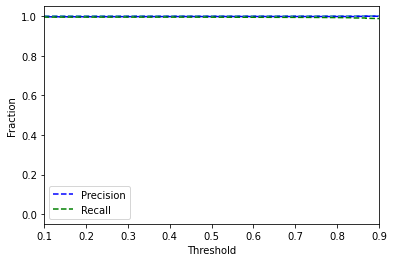

In [146]:
print_metrics(clf, X_train, y_train, cv=3)
plot_precision_recall_vs_threshold(clf, X_train, y_train, cv=3,
                                   xlim=(0.1,0.9))

Looks like overtraining

In [147]:
# Now, on the test data
#X_test_tr = gs_lr_tfidf.predict(X_test)

In [148]:
#X_test_tr.sum() / X_test_tr.shape[0]

In [149]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [150]:
print_metrics(clf, X_test, y_test, cv=3)

Using 3 fold of cross validation obtained the following metrics:
Confusion matrix:
 [[971   2]
 [  6 142]]
Precision: 0.99
Recall: 0.96
F1 score: 0.97


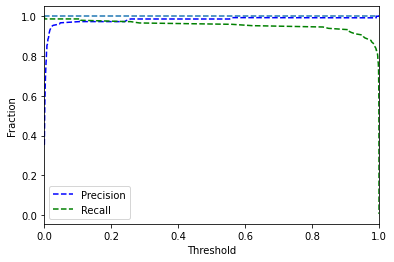

In [151]:
plot_precision_recall_vs_threshold(clf, X_test, y_test, cv=3,
                                   xlim=(0.0,1.0))

Looks reasonable

In [157]:
type(X_test[0])

str

In [164]:
# Pretend we have new messages
X_new = np.array(["Click the link below and you will win $1000",
                  "<a> <ab> <ac> The US governemt has granted you $100000. Send your ID and credit card details.",
                  "Hi John, how are you? Long time no see.",
                  "Hey, I'm a sexy and intelligent girl. I like to hang out",
                  "The construction bank of China offers you $10000 if you send me $1000"])
clf.predict(X_new)

array([0, 0, 0, 0, 0])

## Out-of-core learning

To speed up training and optimisation, we will use out-of-core learning, wherein the model is updated with a subset of the training documents.

First, we need to encapsulate the pre-processing and tokenising steps into a function.

In [188]:
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')
def cleaner(text):
    """Let's clean the message, tokenize the result and remove stop words
    
    Cleaning does the following:
    - removing end-of-line characters and other non-word characters
    - replace $ by `_dollar_`
    - replacing HTML with `_HTML_` (spam has more HTML probably)
    - replacing numbers with `_number_`
    - replacing incorrect English with `_INCORRECT_ENG_`
    """
    text = re.sub(r'<[^>]*>', ' _HTML_ ', text)
    text = re.sub(r'\$', ' _DOLLAR_ ', text)  
    text = ' '.join([w if correct_english(w) else " _INCORRECT_ENG_ " for w in text.split()])
    text = re.sub(r'[0-9]+\.?[0-9]*', ' _NUMBER_ ', text)
    # remove non-words (NB. does not remove incorrect 'words')
    text = re.sub(r'[\W]+', ' ', text) 
    text = [w for w in text.split() if w not in stop]
    return ' '.join(text).lower()
    #TODO: add params and use them in grid search(?)
    
def tokenizer(text):
    return text.split()

We need a generator that reads one document at a time.

In [56]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

Let's use the above function to create a mini-batch of $n$ e-mails.

In [59]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

For out-of-core learning we cannot use the `CountVectorizer`, but we may fall back on the `HashingVectorizer`.

In [63]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=cleaner, # Let's try to use it (split cleaning and tokenizing?)
                         tokenizer=tokenizer)
clf = SGDClassifier(loss='log', random_state=42) # loss=log -> logistic regression
doc_stream = stream_docs('spam_data.csv')

In [64]:
# Use 40 N_BATCHES * BATCH_SIZE documents for training
N_BATCHES = 4
BATCH_SIZE = 1000
import pyprind
pbar = pyprind.ProgBar(N_BATCHES)
classes = np.array([0,1])
for _ in range(N_BATCHES):
    X_train, y_train = get_minibatch(doc_stream, size=BATCH_SIZE)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [####] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


In [65]:
X_test, y_test = get_minibatch(doc_stream, size=1885) # TODO: hard-coded!
X_test = vect.transform(X_test)
clf.score(X_test, y_test)
# TODO: can use recall and precision or f1 as score?
# TODO: Can use pipeline?

0.9241379310344827

## How spam is caught? Topic modelling with Latent Dirichlet Allocation

In [47]:
import pandas as pd
df = pd.read_csv('spam_data.csv', encoding='utf-8')

In [48]:
# Select only spam
df = df[df["type"]==1]

In [195]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
count = CountVectorizer(stop_words='english', 
                        max_df=1.0,
                        max_features=5000)
lda = LatentDirichletAllocation(n_components=10,
                                random_state=42,
                                learning_method='batch',
                                n_jobs=-1)
pipe = Pipeline([('clean', Cleaner()),
                 ('vect', count),
                 ('lda', lda),
                ])
lda_topics = pipe.fit_transform(df['message'].values)

In [196]:

lda.components_.shape

(10, 4833)

In [197]:
n_top_words = 15
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d" % (topic_idx+1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                    [:-n_top_words - 1:-1]]))

Topic 1
courteous breast enhancement sizes bust repaired upgrades engineer english bother russian intimidate www aver lift
Topic 2
courteous breast enhancement sizes bust repaired upgrades engineer english bother russian intimidate www aver lift
Topic 3
_incorrect_eng_ _number_ money business people make free mail grants government email send million report day
Topic 4
courteous breast enhancement sizes bust repaired upgrades engineer english bother russian intimidate www aver lift
Topic 5
_incorrect_eng_ _number_ id aug click free email microsoft receive information mail jalapeno message service list
Topic 6
courteous breast enhancement sizes bust repaired upgrades engineer english bother russian intimidate www aver lift
Topic 7
courteous breast enhancement sizes bust repaired upgrades engineer english bother russian intimidate www aver lift
Topic 8
courteous breast enhancement sizes bust repaired upgrades engineer english bother russian intimidate www aver lift
Topic 9
courteous brea

In [193]:
np.arange(10)[:-3-1:-1]

array([9, 8, 7])

In [194]:
#TODO: check spam filter on real-world examples (just for private curiosity)